In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import itertools
import itertools
import math
import time
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR as SVMRegressor
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
plt.style.use('fivethirtyeight')
%matplotlib inline
#%matplotlib notebook
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# 1. Feature Engineering

In [2]:
# READ IN DATA
df_original = pd.read_csv('./data/norphlet_subset_moving_window_additional_features_20200704.csv', encoding='utf8',
                dtype={'wellname': str, 'field': str,  'field_part': str, 'filename' : str,
                       'wellname_old': str, 'dataset_name': str, 'depth_range': str})

df_original = df_original[[c for c in df_original.columns if 'Unnamed' not in c]]

In [7]:
# 2 = water
df_original['fluid'].value_counts()

2.0    12516
1.0     1757
Name: fluid, dtype: int64

In [10]:
print(df_original.shape)
df_original = df_original[df_original['fluid'] == 2.0]
print(df_original.shape)

(12516, 248)
(12516, 248)


In [11]:
# MAIN FEATURES
corr_features = ['density_g_cm3', 'rdeep_ohm_m', 'gr_gapi', 'neutron_cfcf', 'nmr_ff_vv', 'nmr_tpor_vv', 'dt']

In [12]:
# THESE FEATURES ARE CORRELATED WITH NMR_TPOR AND NMR_FF
nmrtpor_features = ['dt_absolute_sum_of_changes', 'dt_cid_ce', 'dt_mean_abs_change', 'dt_standard_deviation', 'dt_variance',
                    'dt_variation_coefficient', 'gr_gapi_absolute_sum_of_changes', 'gr_gapi_cid_ce', 'gr_gapi_maximum',
                    'gr_gapi_mean_abs_change', 'gr_gapi_standard_deviation', 'gr_gapi_variance',
                    'gr_gapi_variation_coefficient', 'neutron_cfcf_abs_energy', 'rdeep_ohm_m_abs_energy',
                    'rdeep_ohm_m_absolute_sum_of_changes', 'rdeep_ohm_m_cid_ce', 'rdeep_ohm_m_mean_abs_change',
                    'rdeep_ohm_m_minimum', 'rdeep_ohm_m_standard_deviation', 'rdeep_ohm_m_variance']

nmrff_features   = ['density_g_cm3_abs_energy','dt_abs_energy','dt_absolute_sum_of_changes','dt_cid_ce','dt_mean_abs_change',
                    'dt_minimum', 'gr_gapi_absolute_sum_of_changes', 'gr_gapi_cid_ce', 'gr_gapi_maximum',
                    'gr_gapi_mean_abs_change','gr_gapi_standard_deviation','gr_gapi_variance','gr_gapi_variation_coefficient',
                    'neutron_cfcf_abs_energy', 'rdeep_ohm_m_minimum']


# THESE FEATURES ARE CORRELATED WITH OTHER 5 MAIN FEATURES (NOT NMT_TPOR OR NMR_FF)
other_features   = ['density_g_cm3_minimum', 'dt_maximum', 'dt_mean', 'dt_sum_values', 'gr_gapi_minimum',
                    'neutron_cfcf_absolute_sum_of_changes', 'neutron_cfcf_cid_ce',
                    'neutron_cfcf_maximum', 'neutron_cfcf_mean_abs_change']


# NMR_TPOR AND NMR_FF SUBFEATURES CORRELATED WITH OTHER MAIN FEATURES
nmrtpor_sub      = ['nmr_tpor_vv_cid_ce', 'nmr_tpor_vv_mean_abs_change', 'nmr_tpor_vv_absolute_sum_of_changes',
                    'nmr_tpor_vv_longest_strike_below_mean']

nmrff_sub        = ['nmr_ff_vv_cid_ce', 'nmr_ff_vv_mean_abs_change', 'nmr_ff_vv_absolute_sum_of_changes',
                    'nmr_ff_vv_longest_strike_below_mean']

additional_features = sorted(list(set(nmrtpor_features + nmrff_features + other_features + nmrtpor_sub + nmrff_sub)))
print('Length of additional features:', len(additional_features))

Length of additional features: 41


In [13]:
dt_features = [i for i in additional_features if 'dt_' in i]
gr_features = [i for i in additional_features if 'gr_gapi_' in i]
rd_deatures = [i for i in additional_features if 'rdeep_' in i]

In [14]:
print(df_original.shape)
df_original.head()

(12516, 248)


,wellname,field,field_part,md_ft,density_g_cm3,dtc_us_ft,dts_us_ft,fluid,gr_gapi,neutron_cfcf,nmr_bw_vv,nmr_cbw_vv,nmr_ff_vv,nmr_tpor_vv,rdeep_ohm_m,tvd_ft,tvdbml_ft,tvdss_ft,filename,wellname_old,dataset_name,rmedium_ohm_m,rshallow_ohm_m,dt,density_g_cm3_abs_energy,density_g_cm3_absolute_sum_of_changes,density_g_cm3_cid_ce,density_g_cm3_count_above_mean,density_g_cm3_count_below_mean,density_g_cm3_first_location_of_maximum,density_g_cm3_first_location_of_minimum,density_g_cm3_last_location_of_maximum,density_g_cm3_last_location_of_minimum,density_g_cm3_has_duplicate_max,density_g_cm3_has_duplicate_min,density_g_cm3_kurtosis,density_g_cm3_longest_strike_above_mean,density_g_cm3_longest_strike_below_mean,density_g_cm3_minimum,density_g_cm3_maximum,density_g_cm3_mean,density_g_cm3_median,density_g_cm3_mean_change,density_g_cm3_mean_abs_change,density_g_cm3_mean_second_derivative_central,density_g_cm3_percentage_of_reoccurring_datapoints_to_all_datapoints,density_g_cm3_ratio_beyond_r_sigma,density_g_cm3_ratio_value_number_to_time_series_length,density_g_cm3_sample_entropy,density_g_cm3_skewness,density_g_cm3_standard_deviation,density_g_cm3_sum_of_reoccurring_data_points,density_g_cm3_sum_of_reoccurring_values,density_g_cm3_sum_values,density_g_cm3_variance,density_g_cm3_variation_coefficient,rdeep_ohm_m_abs_energy,rdeep_ohm_m_absolute_sum_of_changes,rdeep_ohm_m_cid_ce,rdeep_ohm_m_count_above_mean,rdeep_ohm_m_count_below_mean,rdeep_ohm_m_first_location_of_maximum,rdeep_ohm_m_first_location_of_minimum,rdeep_ohm_m_last_location_of_maximum,rdeep_ohm_m_last_location_of_minimum,rdeep_ohm_m_has_duplicate_max,rdeep_ohm_m_has_duplicate_min,rdeep_ohm_m_kurtosis,rdeep_ohm_m_longest_strike_above_mean,rdeep_ohm_m_longest_strike_below_mean,rdeep_ohm_m_minimum,rdeep_ohm_m_maximum,rdeep_ohm_m_mean,rdeep_ohm_m_median,rdeep_ohm_m_mean_change,rdeep_ohm_m_mean_abs_change,rdeep_ohm_m_mean_second_derivative_central,rdeep_ohm_m_percentage_of_reoccurring_datapoints_to_all_datapoints,rdeep_ohm_m_ratio_beyond_r_sigma,rdeep_ohm_m_ratio_value_number_to_time_series_length,rdeep_ohm_m_sample_entropy,rdeep_ohm_m_skewness,rdeep_ohm_m_standard_deviation,rdeep_ohm_m_sum_of_reoccurring_data_points,rdeep_ohm_m_sum_of_reoccurring_values,rdeep_ohm_m_sum_values,rdeep_ohm_m_variance,rdeep_ohm_m_variation_coefficient,gr_gapi_abs_energy,gr_gapi_absolute_sum_of_changes,gr_gapi_cid_ce,gr_gapi_count_above_mean,gr_gapi_count_below_mean,gr_gapi_first_location_of_maximum,gr_gapi_first_location_of_minimum,gr_gapi_last_location_of_maximum,gr_gapi_last_location_of_minimum,gr_gapi_has_duplicate_max,gr_gapi_has_duplicate_min,gr_gapi_kurtosis,gr_gapi_longest_strike_above_mean,gr_gapi_longest_strike_below_mean,gr_gapi_minimum,gr_gapi_maximum,gr_gapi_mean,gr_gapi_median,gr_gapi_mean_change,gr_gapi_mean_abs_change,gr_gapi_mean_second_derivative_central,gr_gapi_percentage_of_reoccurring_datapoints_to_all_datapoints,gr_gapi_ratio_beyond_r_sigma,gr_gapi_ratio_value_number_to_time_series_length,gr_gapi_sample_entropy,gr_gapi_skewness,gr_gapi_standard_deviation,gr_gapi_sum_of_reoccurring_data_points,gr_gapi_sum_of_reoccurring_values,gr_gapi_sum_values,gr_gapi_variance,gr_gapi_variation_coefficient,neutron_cfcf_abs_energy,neutron_cfcf_absolute_sum_of_changes,neutron_cfcf_cid_ce,neutron_cfcf_count_above_mean,neutron_cfcf_count_below_mean,neutron_cfcf_first_location_of_maximum,neutron_cfcf_first_location_of_minimum,neutron_cfcf_last_location_of_maximum,neutron_cfcf_last_location_of_minimum,neutron_cfcf_has_duplicate_max,neutron_cfcf_has_duplicate_min,neutron_cfcf_kurtosis,neutron_cfcf_longest_strike_above_mean,neutron_cfcf_longest_strike_below_mean,neutron_cfcf_minimum,neutron_cfcf_maximum,neutron_cfcf_mean,neutron_cfcf_median,neutron_cfcf_mean_change,neutron_cfcf_mean_abs_change,neutron_cfcf_mean_second_derivative_central,neutron_cfcf_percentage_of_reoccurring_datapoints_to_all_datapoints,neutron_cfcf_ratio_beyond_r_sigma,neutron_cfcf_ratio_value_number_to_time_series_length,neutron_cfcf_sam

In [15]:
df_original['wellname'].unique()

array(['MC348-3ST1', 'MC391-1', 'MC392-1', 'MC392-1ST1', 'MC393-1',
       'MC525-2', 'MC612-1BP1'], dtype=object)

In [16]:
df_original[corr_features + additional_features].isna().sum()

density_g_cm3                            0
rdeep_ohm_m                              0
gr_gapi                                  0
neutron_cfcf                             0
nmr_ff_vv                                0
nmr_tpor_vv                              0
dt                                       0
density_g_cm3_abs_energy                 0
density_g_cm3_minimum                    0
dt_abs_energy                            0
dt_absolute_sum_of_changes               0
dt_cid_ce                                0
dt_maximum                               0
dt_mean                                  0
dt_mean_abs_change                       0
dt_minimum                               0
dt_standard_deviation                    0
dt_sum_values                            0
dt_variance                              0
dt_variation_coefficient                 0
gr_gapi_absolute_sum_of_changes          0
gr_gapi_cid_ce                           0
gr_gapi_maximum                          0
gr_gapi_mea

In [17]:
# DATA POINTS PER WELL
print('Data points per well:')
for well in df_original['wellname'].unique():
    print('\t{}: {} datapoints'.format(well, df_original[df_original['wellname'] == well].shape[0]))

Data points per well:
	MC348-3ST1: 551 datapoints
	MC391-1: 2713 datapoints
	MC392-1: 950 datapoints
	MC392-1ST1: 3032 datapoints
	MC393-1: 2709 datapoints
	MC525-2: 874 datapoints
	MC612-1BP1: 1687 datapoints


In [18]:
# OIL = 2, WATER = 1
df_original['fluid'].value_counts()

2.0    12516
Name: fluid, dtype: int64

In [19]:
# DATA POINTS PER WELL IN OIL
print('Data points per well in oil:')
for well in df_original['wellname'].unique():
    print('\t{}: {} datapoints'.format(well, df_original[(df_original['wellname'] == well) & (df_original['fluid'] == 2)].shape[0]))

Data points per well in oil:
	MC348-3ST1: 551 datapoints
	MC391-1: 2713 datapoints
	MC392-1: 950 datapoints
	MC392-1ST1: 3032 datapoints
	MC393-1: 2709 datapoints
	MC525-2: 874 datapoints
	MC612-1BP1: 1687 datapoints


#### Only the last three wells have water

In [20]:
print('Min depth:', df_original['tvdss_ft'].min())
print('Max depth:', df_original['tvdss_ft'].max())
print('Difference:', math.ceil(df_original['tvdss_ft'].max() - df_original['tvdss_ft'].min()))

Min depth: 24320.04
Max depth: 28316.785539354398
Difference: 3997


In [21]:
# ZERO DUPLICATES
df_original[df_original[corr_features + additional_features].duplicated()]

,wellname,field,field_part,md_ft,density_g_cm3,dtc_us_ft,dts_us_ft,fluid,gr_gapi,neutron_cfcf,nmr_bw_vv,nmr_cbw_vv,nmr_ff_vv,nmr_tpor_vv,rdeep_ohm_m,tvd_ft,tvdbml_ft,tvdss_ft,filename,wellname_old,dataset_name,rmedium_ohm_m,rshallow_ohm_m,dt,density_g_cm3_abs_energy,density_g_cm3_absolute_sum_of_changes,density_g_cm3_cid_ce,density_g_cm3_count_above_mean,density_g_cm3_count_below_mean,density_g_cm3_first_location_of_maximum,density_g_cm3_first_location_of_minimum,density_g_cm3_last_location_of_maximum,density_g_cm3_last_location_of_minimum,density_g_cm3_has_duplicate_max,density_g_cm3_has_duplicate_min,density_g_cm3_kurtosis,density_g_cm3_longest_strike_above_mean,density_g_cm3_longest_strike_below_mean,density_g_cm3_minimum,density_g_cm3_maximum,density_g_cm3_mean,density_g_cm3_median,density_g_cm3_mean_change,density_g_cm3_mean_abs_change,density_g_cm3_mean_second_derivative_central,density_g_cm3_percentage_of_reoccurring_datapoints_to_all_datapoints,density_g_cm3_ratio_beyond_r_sigma,density_g_cm3_ratio_value_number_to_time_series_length,density_g_cm3_sample_entropy,density_g_cm3_skewness,density_g_cm3_standard_deviation,density_g_cm3_sum_of_reoccurring_data_points,density_g_cm3_sum_of_reoccurring_values,density_g_cm3_sum_values,density_g_cm3_variance,density_g_cm3_variation_coefficient,rdeep_ohm_m_abs_energy,rdeep_ohm_m_absolute_sum_of_changes,rdeep_ohm_m_cid_ce,rdeep_ohm_m_count_above_mean,rdeep_ohm_m_count_below_mean,rdeep_ohm_m_first_location_of_maximum,rdeep_ohm_m_first_location_of_minimum,rdeep_ohm_m_last_location_of_maximum,rdeep_ohm_m_last_location_of_minimum,rdeep_ohm_m_has_duplicate_max,rdeep_ohm_m_has_duplicate_min,rdeep_ohm_m_kurtosis,rdeep_ohm_m_longest_strike_above_mean,rdeep_ohm_m_longest_strike_below_mean,rdeep_ohm_m_minimum,rdeep_ohm_m_maximum,rdeep_ohm_m_mean,rdeep_ohm_m_median,rdeep_ohm_m_mean_change,rdeep_ohm_m_mean_abs_change,rdeep_ohm_m_mean_second_derivative_central,rdeep_ohm_m_percentage_of_reoccurring_datapoints_to_all_datapoints,rdeep_ohm_m_ratio_beyond_r_sigma,rdeep_ohm_m_ratio_value_number_to_time_series_length,rdeep_ohm_m_sample_entropy,rdeep_ohm_m_skewness,rdeep_ohm_m_standard_deviation,rdeep_ohm_m_sum_of_reoccurring_data_points,rdeep_ohm_m_sum_of_reoccurring_values,rdeep_ohm_m_sum_values,rdeep_ohm_m_variance,rdeep_ohm_m_variation_coefficient,gr_gapi_abs_energy,gr_gapi_absolute_sum_of_changes,gr_gapi_cid_ce,gr_gapi_count_above_mean,gr_gapi_count_below_mean,gr_gapi_first_location_of_maximum,gr_gapi_first_location_of_minimum,gr_gapi_last_location_of_maximum,gr_gapi_last_location_of_minimum,gr_gapi_has_duplicate_max,gr_gapi_has_duplicate_min,gr_gapi_kurtosis,gr_gapi_longest_strike_above_mean,gr_gapi_longest_strike_below_mean,gr_gapi_minimum,gr_gapi_maximum,gr_gapi_mean,gr_gapi_median,gr_gapi_mean_change,gr_gapi_mean_abs_change,gr_gapi_mean_second_derivative_central,gr_gapi_percentage_of_reoccurring_datapoints_to_all_datapoints,gr_gapi_ratio_beyond_r_sigma,gr_gapi_ratio_value_number_to_time_series_length,gr_gapi_sample_entropy,gr_gapi_skewness,gr_gapi_standard_deviation,gr_gapi_sum_of_reoccurring_data_points,gr_gapi_sum_of_reoccurring_values,gr_gapi_sum_values,gr_gapi_variance,gr_gapi_variation_coefficient,neutron_cfcf_abs_energy,neutron_cfcf_absolute_sum_of_changes,neutron_cfcf_cid_ce,neutron_cfcf_count_above_mean,neutron_cfcf_count_below_mean,neutron_cfcf_first_location_of_maximum,neutron_cfcf_first_location_of_minimum,neutron_cfcf_last_location_of_maximum,neutron_cfcf_last_location_of_minimum,neutron_cfcf_has_duplicate_max,neutron_cfcf_has_duplicate_min,neutron_cfcf_kurtosis,neutron_cfcf_longest_strike_above_mean,neutron_cfcf_longest_strike_below_mean,neutron_cfcf_minimum,neutron_cfcf_maximum,neutron_cfcf_mean,neutron_cfcf_median,neutron_cfcf_mean_change,neutron_cfcf_mean_abs_change,neutron_cfcf_mean_second_derivative_central,neutron_cfcf_percentage_of_reoccurring_datapoints_to_all_datapoints,neutron_cfcf_ratio_beyond_r_sigma,neutron_cfcf_ratio_value_number_to_time_series_length,neutron_cfcf_sam

In [22]:
# ALL NUMERIC FIELDS
to_exclude = ['md_ft', 'dtc_us_ft', 'dts_us_ft', 'fluid', 'nmr_bw_vv', 'nmr_cbw_vv', 'wellname', 'field', 'field_part',
              'filename', 'wellname_old', 'dataset_name', 'tvd_ft', 'tvdbml_ft', 'tvdss_ft', 'rmedium_ohm_m', 'rshallow_ohm_m',
              'density_g_cm3_sample_entropy', 'rdeep_ohm_m_sample_entropy', 'gr_gapi_sample_entropy',
              'neutron_cfcf_sample_entropy', 'nmr_ff_vv_sample_entropy', 'nmr_tpor_vv_sample_entropy', 'dt_sample_entropy']
bool_cols = [col for col in df_original.columns if df_original[col].dtype == bool]
to_exclude = to_exclude + bool_cols

to_include = [col for col in df_original.columns if col not in to_exclude]

In [23]:
len(to_include)

210

In [24]:
corr_features

['density_g_cm3',
 'rdeep_ohm_m',
 'gr_gapi',
 'neutron_cfcf',
 'nmr_ff_vv',
 'nmr_tpor_vv',
 'dt']

In [25]:
winner_prefixes = ['_cid_ce', '_mean_abs_change', '_standard_deviation']    #'_absolute_sum_of_changes', '_variation_coefficient', '_abs_energy', '_variance'

winner_features2 = [i + '_mean' for i in corr_features]

winner_features = []
for item in winner_prefixes:
    temp = [i for i in to_include if item in i]
    winner_features.extend(temp)
    
winner_features = sorted(list(set(winner_features + winner_features2)))
#winner_features = [i for i in winner_features if 'rdeep_' in i or 'neutron_' in i or 'density_' in i]
len(winner_features)

28

In [26]:
# nmrtpor_features + nmrff_features + other_features + nmrtpor_sub + nmrff_sub
#df_features, gr_features, rd_deatures
select_features = sorted(list(set(winner_features + nmrff_features)))
all_features = corr_features
#all_features = [i for i in all_features if 'density' not in i]
print('Length of all features:', len(all_features))

Length of all features: 7


In [27]:
all_features = [i for i in all_features if 'nmr_tpor' not in i]
df_original[all_features].head(21)

,density_g_cm3,rdeep_ohm_m,gr_gapi,neutron_cfcf,nmr_ff_vv,dt
0,3.1089,0.293561,26.304100,0.251625,0.001510,0.663901
1,3.1126,0.365731,23.341801,0.222850,0.002170,0.663968
2,3.0757,0.512044,21.169090,0.203550,0.002365,0.664013
3,3.0079,0.681784,20.145300,0.187125,0.003945,0.660162
4,2.9167,0.827608,18.498600,0.173575,0.012790,0.656260
5,2.7429,0.900127,17.048950,0.167300,0.027430,0.640998
6,2.6334,0.904802,16.085649,0.168300,0.040665,0.625687
7,2.5835,0.876887,16.102949,0.168850,0.051810,0.635057
8,2.5735,0.885859,16.727200,0.168950,0.053110,0.644306
9,2.5424,0.927304,17.851200,0.166975,0.074975,0.653685


# 2. Predicting NMR_FF

In [28]:
# f(x) to plot regressor results
def plot_results(_actuals, _preds, _rmse, _mae, _r2, diff):
           
    fig = plt.figure(figsize=(15, 4))
    plt.subplot(1, 1, 1)
    
    plt.title('Testing on unseen data (RMSE={} or {}%, MAE={} or {}%, R2={})'.format(round(_rmse, 5),
                                                                                     round((_rmse * 100) / diff, 2),
                                                                                     round(_mae, 5),
                                                                                     round((_mae * 100) / diff, 2),
                                                                                     round(_r2, 5)
                                                                                    )
             )
    
    plt.plot(_actuals, 'b-', label='Actual values', linewidth=0.75)
    plt.plot(_preds, 'r-', label='Predicted values', linewidth=0.75)
    plt.legend(loc='upper right')
    plt.xlabel('Index')
    plt.ylabel('NMR_FF')
    fig.tight_layout()
    plt.show()

## 1. SVM Regressor (best performance)

In [29]:
def svm_reg(df, _all_features, well_name, plotting=False):
        
    # one of all_features is target to be predicted
    _target = 'nmr_ff_vv'
    _features = [i for i in _all_features if i != _target]
        
    # train / test split
    df = deepcopy(df)
    test_index = df[df['wellname'] == well_name].index
    X_test = df.loc[test_index][_features].values
    y_test = df.loc[test_index][_target].values.reshape(-1, 1)
    
    X_train = df[_features].drop(test_index).values
    y_train = df[_target].drop(test_index).values.reshape(-1, 1)
    if plotting:
        print(' Test set: {} data points (well {})'.format(X_test.shape[0], well_name))
        print('Train set: {} data points (all other wells)'.format(X_train.shape[0]))
        
    # fit scaler on train set and apply to both train and test sets
    feature_scaler, target_scaler = StandardScaler(), StandardScaler()
    feature_scaler.fit(X_train)
    target_scaler.fit(y_train)
    
    X_train, X_test = feature_scaler.transform(X_train), feature_scaler.transform(X_test)
    y_train, y_test = target_scaler.transform(y_train), target_scaler.transform(y_test)
        
    # train and test model, inverse transform predictions (best n_neighbors=50)
    regressor = SVMRegressor(kernel='linear', tol=0.001, C=1.0, epsilon=0.1)
    regressor.fit(X_train, y_train)
    _r2 = regressor.score(X_test, y_test)
    yhat = regressor.predict(X_test)
    yhat = target_scaler.inverse_transform(yhat)
        
    # estimate metrics and plot results
    _rmse = mean_squared_error(df.loc[test_index][_target].values, yhat, squared=False)          # False for rmse
    _mae  = mean_absolute_error(df.loc[test_index][_target].values, yhat)
    diff = df['nmr_ff_vv'].max() - df['nmr_ff_vv'].min()                                         # to calculate percentage
    
    if plotting:
        plot_results(df.loc[test_index][_target].values, yhat, _rmse, _mae, _r2, diff)
        print('\n' + '*'*100 + '\n')
        
        coeff_df = pd.DataFrame({'Feature Importance' : regressor.coef_[0]}, index=_features)
        coeff_df = coeff_df.sort_values(by='Feature Importance')
        coeff_df.plot(kind='barh', figsize=(9, 5), legend=False, title="SVM Regressor: feature importance")
        plt.tight_layout()
        plt.show()
        
        print('\n' + '*'*100 + '\n')
        
    return _rmse, _mae, _r2

Selected features to build model: ['density_g_cm3', 'rdeep_ohm_m', 'gr_gapi', 'neutron_cfcf', 'dt']
    Target value being predicted: ['nmr_ff_vv']

RESULTS FOR TESTING ON WELL MC348-3ST1
 Test set: 551 data points (well MC348-3ST1)
Train set: 11965 data points (all other wells)


C:\Users\andrew.nedilko\Anaconda3\envs\ssedb\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


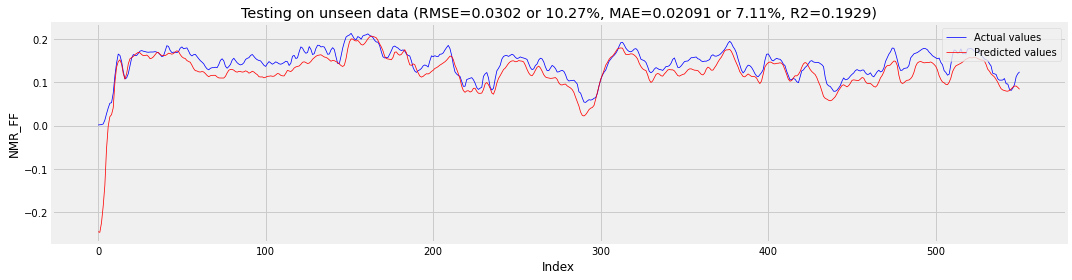


****************************************************************************************************



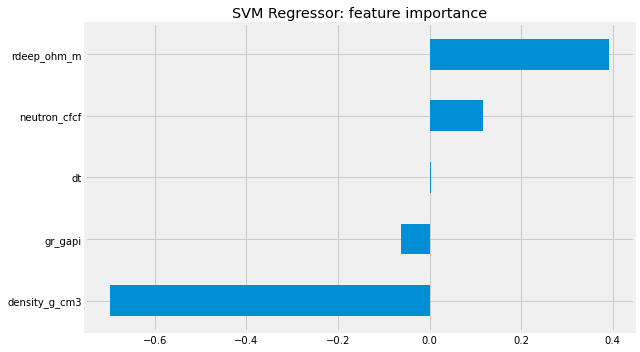


****************************************************************************************************

RESULTS FOR TESTING ON WELL MC391-1
 Test set: 2713 data points (well MC391-1)
Train set: 9803 data points (all other wells)


C:\Users\andrew.nedilko\Anaconda3\envs\ssedb\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


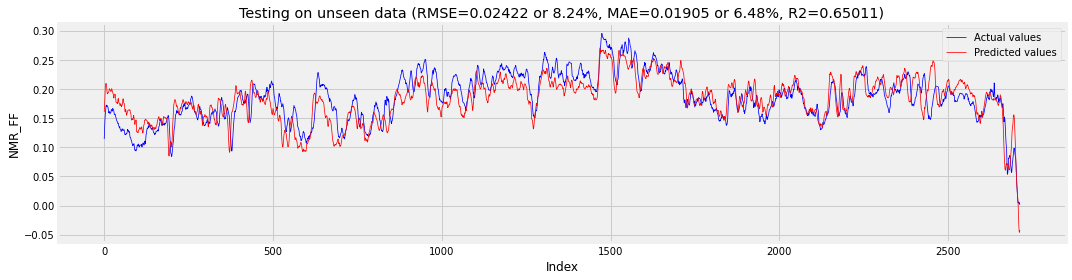


****************************************************************************************************



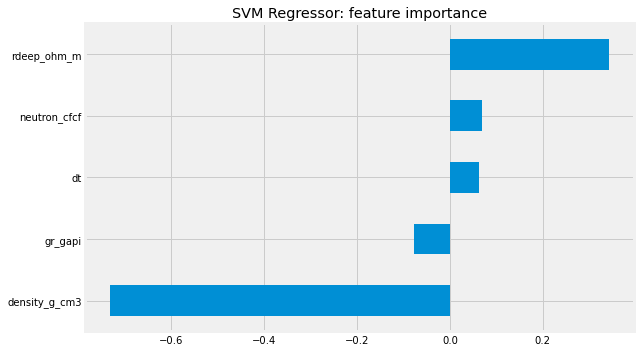


****************************************************************************************************

RESULTS FOR TESTING ON WELL MC392-1
 Test set: 950 data points (well MC392-1)
Train set: 11566 data points (all other wells)


C:\Users\andrew.nedilko\Anaconda3\envs\ssedb\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


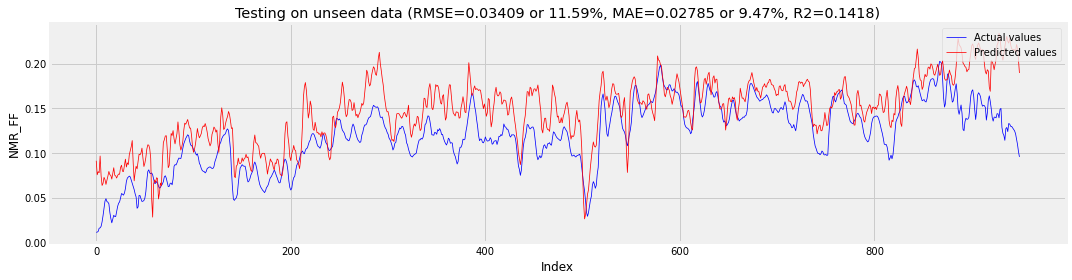


****************************************************************************************************



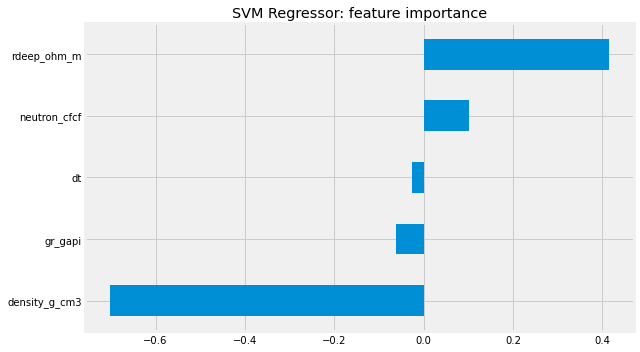


****************************************************************************************************

RESULTS FOR TESTING ON WELL MC392-1ST1
 Test set: 3032 data points (well MC392-1ST1)
Train set: 9484 data points (all other wells)


C:\Users\andrew.nedilko\Anaconda3\envs\ssedb\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


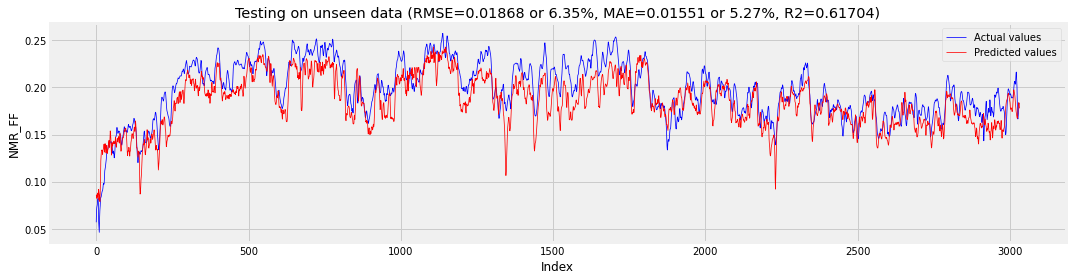


****************************************************************************************************



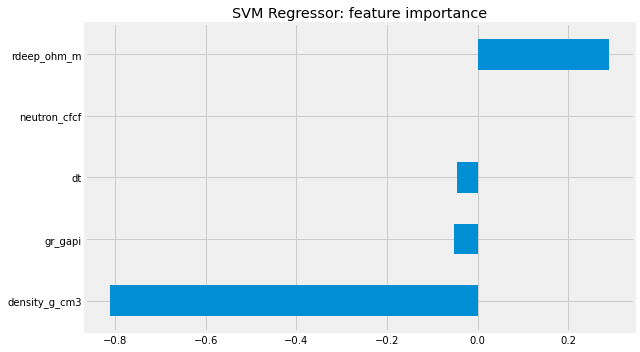


****************************************************************************************************

RESULTS FOR TESTING ON WELL MC393-1
 Test set: 2709 data points (well MC393-1)
Train set: 9807 data points (all other wells)


C:\Users\andrew.nedilko\Anaconda3\envs\ssedb\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


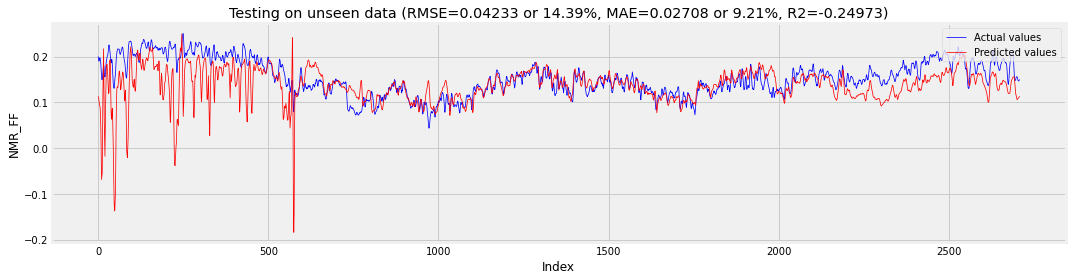


****************************************************************************************************



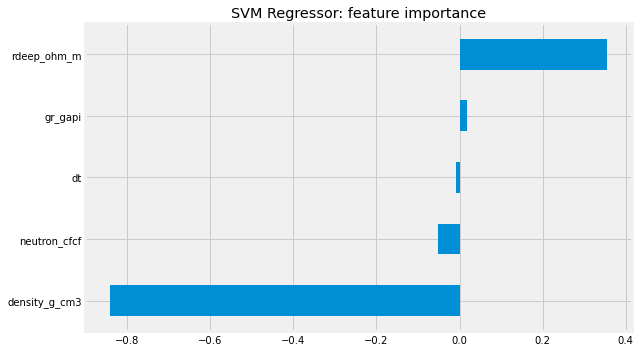


****************************************************************************************************

RESULTS FOR TESTING ON WELL MC525-2
 Test set: 874 data points (well MC525-2)
Train set: 11642 data points (all other wells)


C:\Users\andrew.nedilko\Anaconda3\envs\ssedb\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


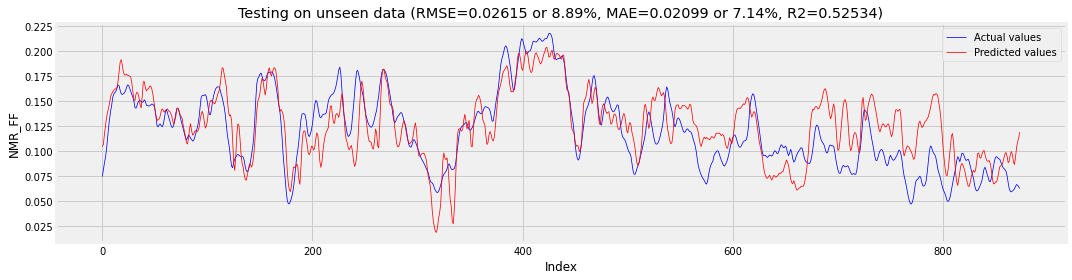


****************************************************************************************************



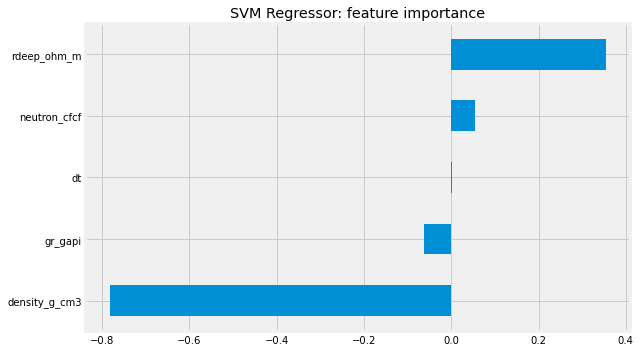


****************************************************************************************************

RESULTS FOR TESTING ON WELL MC612-1BP1
 Test set: 1687 data points (well MC612-1BP1)
Train set: 10829 data points (all other wells)


C:\Users\andrew.nedilko\Anaconda3\envs\ssedb\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


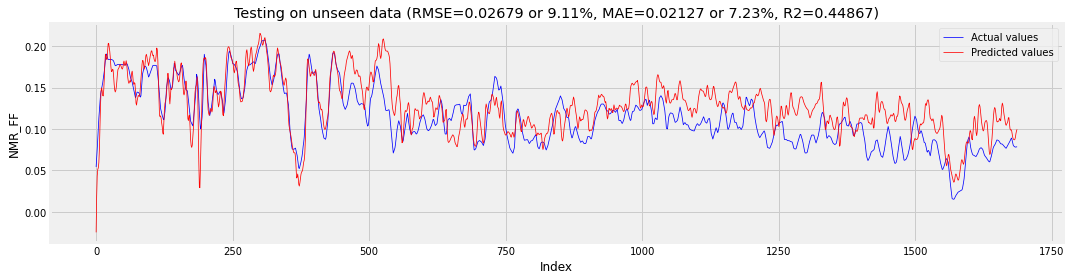


****************************************************************************************************



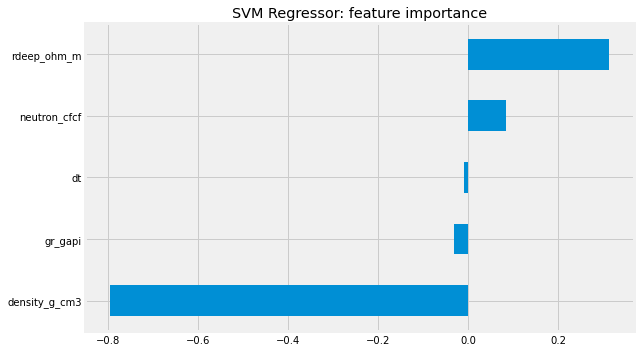


****************************************************************************************************



In [30]:
print('Selected features to build model:', [i for i in all_features if 'nmr' not in i])
print('    Target value being predicted:', [i for i in all_features if 'nmr' in i])
print()

metrics = []
for well in df_original['wellname'].unique():
    print('RESULTS FOR TESTING ON WELL {}'.format(well.upper()))
    rmse, mae, r2 = svm_reg(df_original, all_features, well, plotting=True)
    metrics.append((rmse, mae, r2))

In [31]:
diff = df_original['nmr_ff_vv'].max() - df_original['nmr_ff_vv'].min()
rmse = sum([i[0] for i in metrics]) / len(metrics)
mae  = sum([i[1] for i in metrics]) / len(metrics)
r2   = sum([i[2] for i in metrics]) / len(metrics)

print('Average RMSE = {} which is {}%'.format(round(rmse, 5), round((rmse / diff)*100, 2)))
print('Average MAE  = {} which is {}%'.format(round(mae, 5), round((mae / diff)*100, 2)))
print('Average R2   = {}'.format(round(r2, 5)))

Average RMSE = 0.02892 which is 9.83%
Average MAE  = 0.02181 which is 7.41%
Average R2   = 0.3323


## 2. Other models tried with slightly worse results

## K-Nearest Neighbors
Training on 6 wells / testing on one remaining well

In [32]:
# train / test split by well
def kneighbors(df, _all_features, well_name, plotting=False):
        
    # one of all_features is target to be predicted
    _target = 'nmr_ff_vv'
    _features = [i for i in _all_features if i != _target]
        
    # train / test split
    df = deepcopy(df)
    test_index = df[df['wellname'] == well_name].index
    X_test = df.loc[test_index][_features].values
    y_test = df.loc[test_index][_target].values.reshape(-1, 1)
    
    X_train = df[_features].drop(test_index).values
    y_train = df[_target].drop(test_index).values.reshape(-1, 1)
    if plotting:
        print(' Test set: {} data points (well {})'.format(X_test.shape[0], well_name))
        print('Train set: {} data points (all other wells)'.format(X_train.shape[0]))
        
    # fit scaler on train set and apply to both train and test sets
    feature_scaler, target_scaler = StandardScaler(), StandardScaler()
    feature_scaler.fit(X_train)
    target_scaler.fit(y_train)
    
    X_train, X_test = feature_scaler.transform(X_train), feature_scaler.transform(X_test)
    y_train, y_test = target_scaler.transform(y_train), target_scaler.transform(y_test)
        
    # train and test model, inverse transform predictions (best n_neighbors=50)
    regressor = KNeighborsRegressor(n_neighbors=50, n_jobs=-1)
    regressor.fit(X_train, y_train)
    _r2 = regressor.score(X_test, y_test)
    yhat = regressor.predict(X_test)
    yhat = target_scaler.inverse_transform(yhat)
        
    # estimate metrics and plot results
    _rmse = mean_squared_error(df.loc[test_index][_target].values, yhat, squared=False)          # False for rmse
    _mae  = mean_absolute_error(df.loc[test_index][_target].values, yhat)
    diff = df['nmr_ff_vv'].max() - df['nmr_ff_vv'].min()
    
    if plotting:
        plot_results(df.loc[test_index][_target].values, yhat, _rmse, _mae, _r2, diff)
        print('\n' + '*'*100 + '\n')
        
    return _rmse, _mae, _r2

Selected features to build model: ['density_g_cm3', 'rdeep_ohm_m', 'gr_gapi', 'neutron_cfcf', 'dt']
    Target value being predicted: ['nmr_ff_vv']

RESULTS FOR TESTING ON WELL MC348-3ST1
 Test set: 551 data points (well MC348-3ST1)
Train set: 11965 data points (all other wells)


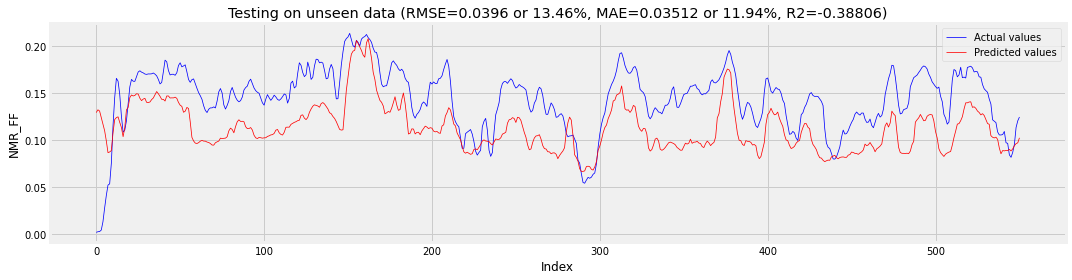


****************************************************************************************************

RESULTS FOR TESTING ON WELL MC391-1
 Test set: 2713 data points (well MC391-1)
Train set: 9803 data points (all other wells)


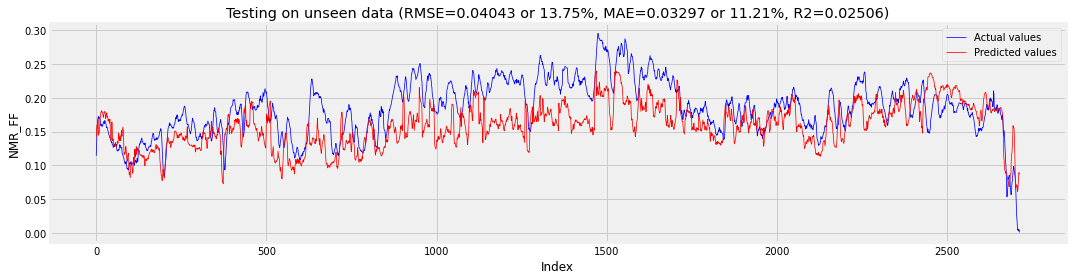


****************************************************************************************************

RESULTS FOR TESTING ON WELL MC392-1
 Test set: 950 data points (well MC392-1)
Train set: 11566 data points (all other wells)


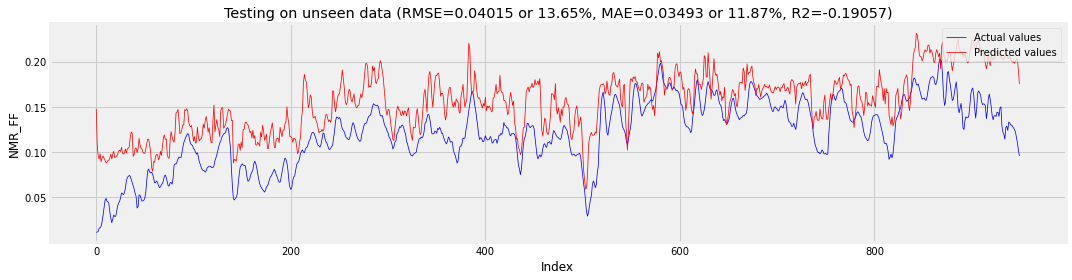


****************************************************************************************************

RESULTS FOR TESTING ON WELL MC392-1ST1
 Test set: 3032 data points (well MC392-1ST1)
Train set: 9484 data points (all other wells)


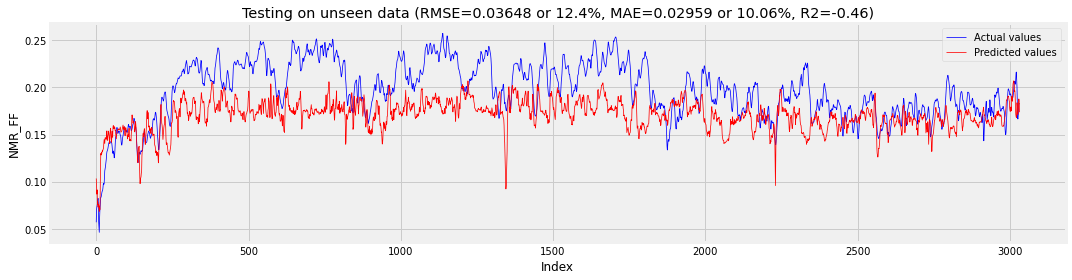


****************************************************************************************************

RESULTS FOR TESTING ON WELL MC393-1
 Test set: 2709 data points (well MC393-1)
Train set: 9807 data points (all other wells)


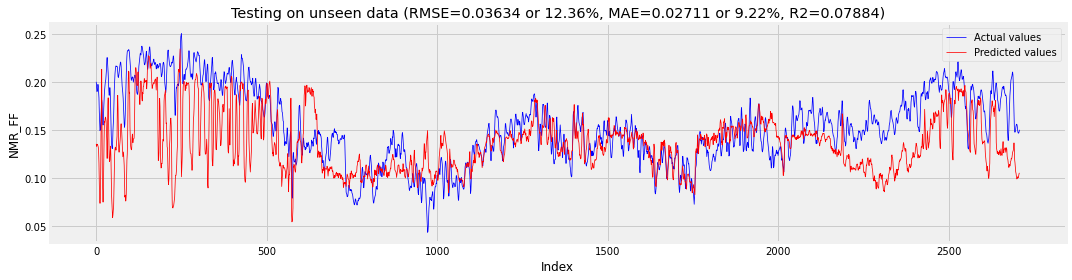


****************************************************************************************************

RESULTS FOR TESTING ON WELL MC525-2
 Test set: 874 data points (well MC525-2)
Train set: 11642 data points (all other wells)


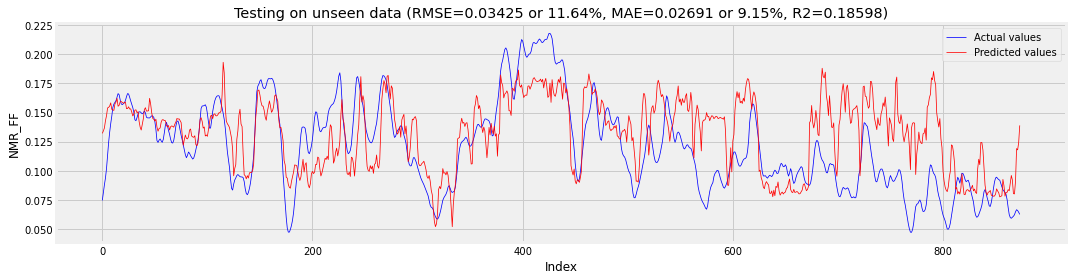


****************************************************************************************************

RESULTS FOR TESTING ON WELL MC612-1BP1
 Test set: 1687 data points (well MC612-1BP1)
Train set: 10829 data points (all other wells)


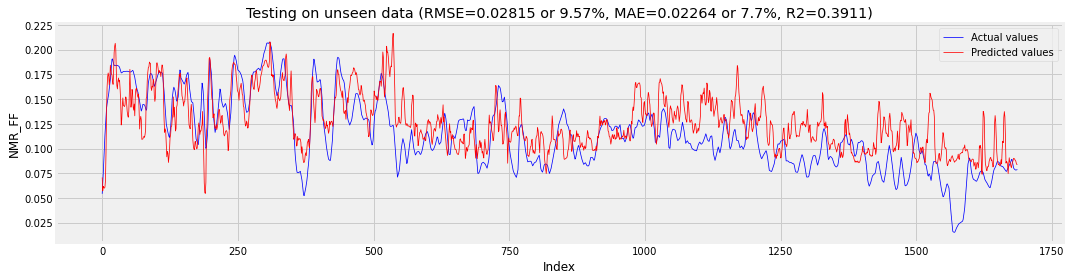


****************************************************************************************************



In [33]:
print('Selected features to build model:', [i for i in all_features if 'nmr' not in i])
print('    Target value being predicted:', [i for i in all_features if 'nmr' in i])
print()

metrics = []
for well in df_original['wellname'].unique():
    print('RESULTS FOR TESTING ON WELL {}'.format(well.upper()))
    rmse, mae, r2 = kneighbors(df_original, all_features, well, plotting=True)
    metrics.append((rmse, mae, r2))

In [34]:
diff = df_original['nmr_ff_vv'].max() - df_original['nmr_ff_vv'].min()
rmse = sum([i[0] for i in metrics]) / len(metrics)
mae  = sum([i[1] for i in metrics]) / len(metrics)
r2   = sum([i[2] for i in metrics]) / len(metrics)

print('Average RMSE = {} which is {}%'.format(round(rmse, 5), round((rmse / diff)*100, 2)))
print('Average MAE  = {} which is {}%'.format(round(mae, 5), round((mae / diff)*100, 2)))
print('Average R2   = {}'.format(round(r2, 5)))

Average RMSE = 0.03649 which is 12.4%
Average MAE  = 0.02989 which is 10.16%
Average R2   = -0.05109


In [35]:
# IF WE HAVE ONLY 7 WELLS, WE CAN CROSS-VALIDATE 7 TIMES ONLY (as the plots below show it)
res = []
j = 1
for i in range(143):
    for well in df_original['wellname'].unique():
        if j % 100 == 0:
            print('Iteration {}'.format(j))
        res.append(kneighbors(df_original, all_features, well))
        j += 1

Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000


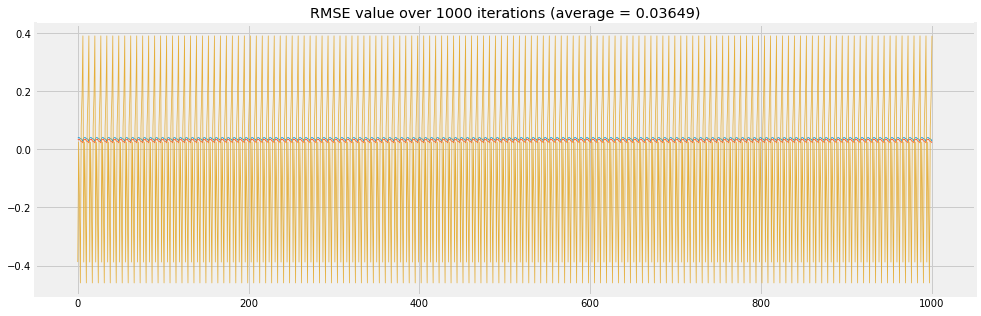

In [36]:
plt.figure(figsize=(15,5))
plt.plot(res, linewidth=0.75)
plt.title('RMSE value over 1000 iterations (average = {})'.format(round(rmse, 5)))
#plt.tight_layout()
plt.show()

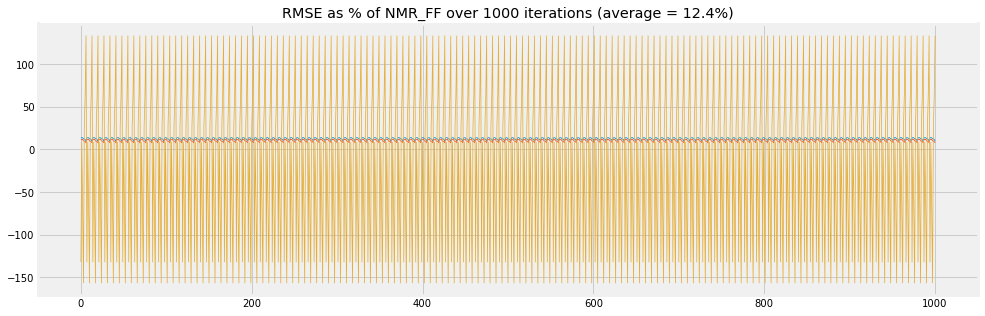

In [37]:
plt.figure(figsize=(15,5))
plt.plot([(i/diff)*100 for i in res], linewidth=0.75)
plt.title('RMSE as % of NMR_FF over 1000 iterations (average = {}%)'.format(round((rmse / diff)*100, 2)))
plt.show()

## Linear Regression

In [38]:
def linear_reg(df, _all_features, well_name, plotting=False):
        
    # one of all_features is target to be predicted
    _target = 'nmr_ff_vv'
    _features = [i for i in _all_features if i != _target]
        
    # train / test split
    df = deepcopy(df)
    test_index = df[df['wellname'] == well_name].index
    X_test = df.loc[test_index][_features].values
    y_test = df.loc[test_index][_target].values.reshape(-1, 1)
    
    X_train = df[_features].drop(test_index).values
    y_train = df[_target].drop(test_index).values.reshape(-1, 1)
    if plotting:
        print(' Test set: {} data points (well {})'.format(X_test.shape[0], well_name))
        print('Train set: {} data points (all other wells)'.format(X_train.shape[0]))
        
    # fit scaler on train set and apply to both train and test sets
    feature_scaler, target_scaler = StandardScaler(), StandardScaler()
    feature_scaler.fit(X_train)
    target_scaler.fit(y_train)
    
    X_train, X_test = feature_scaler.transform(X_train), feature_scaler.transform(X_test)
    y_train, y_test = target_scaler.transform(y_train), target_scaler.transform(y_test)
        
    # train and test model, inverse transform predictions (best n_neighbors=50)
    regressor = LinearRegression()                                     # ElasticNet() LinearRegression()  Ridge()
    regressor.fit(X_train, y_train)
    _r2 = regressor.score(X_test, y_test)
    yhat = regressor.predict(X_test)
    yhat = target_scaler.inverse_transform(yhat)
        
    # estimate metrics and plot results
    _rmse = mean_squared_error(df.loc[test_index][_target].values, yhat, squared=False)          # False for rmse
    _mae  = mean_absolute_error(df.loc[test_index][_target].values, yhat)
    diff = df['nmr_ff_vv'].max() - df['nmr_ff_vv'].min()
    
    if plotting:
        plot_results(df.loc[test_index][_target].values, yhat, _rmse, _mae, _r2, diff)
        print('\n' + '*'*100 + '\n')
        
        coeff_df = pd.DataFrame({'Feature Importance' : regressor.coef_[0]}, index=_features)
        coeff_df = coeff_df.sort_values(by='Feature Importance')
        coeff_df.plot(kind='barh', figsize=(9, 5), legend=False, title="Linear regression: feature importance")
        plt.tight_layout()
        plt.show()
        
        print('\n' + '*'*100 + '\n')
        
    return _rmse, _mae, _r2

Selected features to build model: ['density_g_cm3', 'rdeep_ohm_m', 'gr_gapi', 'neutron_cfcf', 'dt']
    Target value being predicted: ['nmr_ff_vv']

RESULTS FOR TESTING ON WELL MC348-3ST1
 Test set: 551 data points (well MC348-3ST1)
Train set: 11965 data points (all other wells)


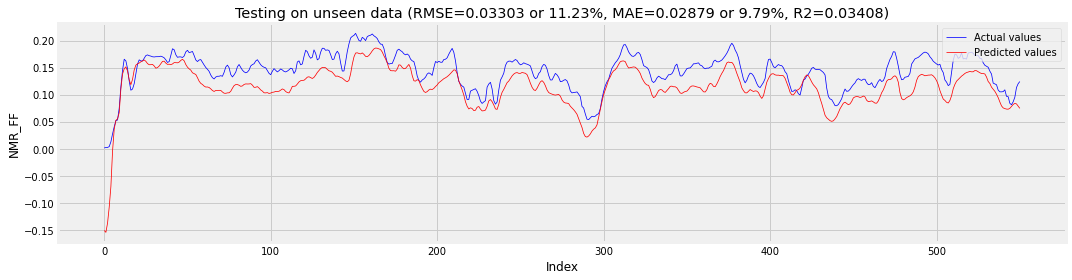


****************************************************************************************************



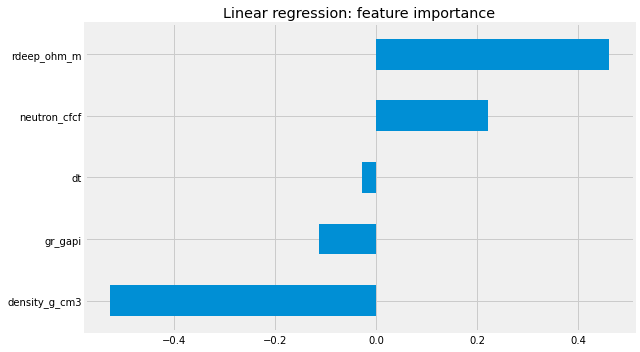


****************************************************************************************************

RESULTS FOR TESTING ON WELL MC391-1
 Test set: 2713 data points (well MC391-1)
Train set: 9803 data points (all other wells)


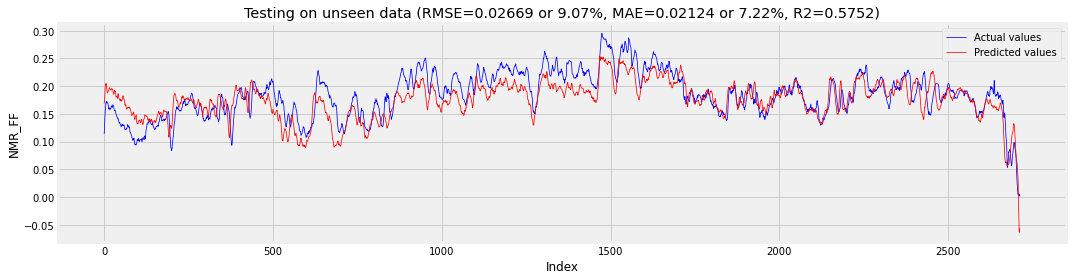


****************************************************************************************************



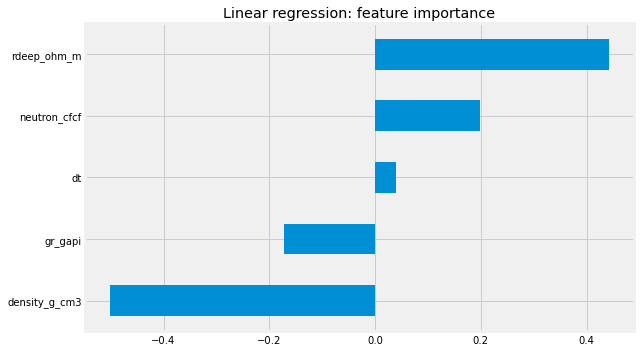


****************************************************************************************************

RESULTS FOR TESTING ON WELL MC392-1
 Test set: 950 data points (well MC392-1)
Train set: 11566 data points (all other wells)


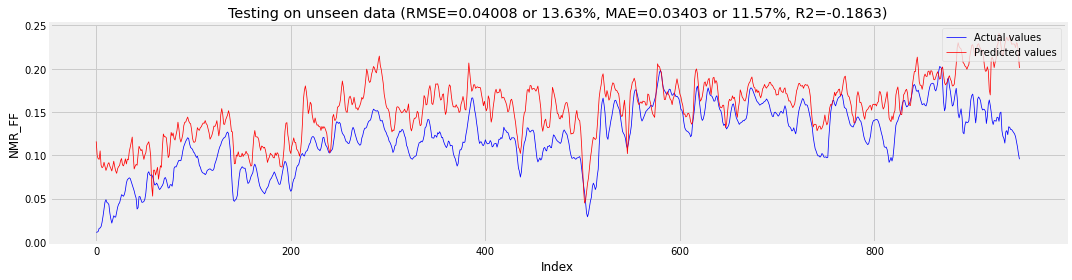


****************************************************************************************************



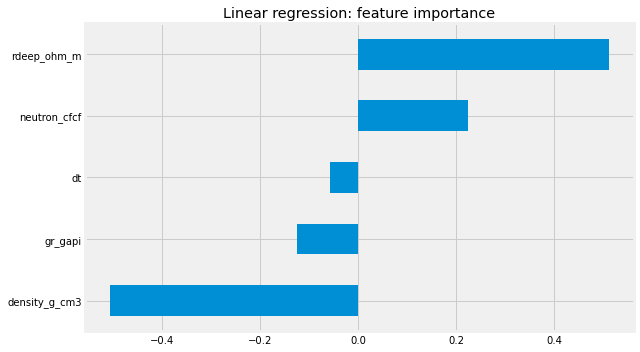


****************************************************************************************************

RESULTS FOR TESTING ON WELL MC392-1ST1
 Test set: 3032 data points (well MC392-1ST1)
Train set: 9484 data points (all other wells)


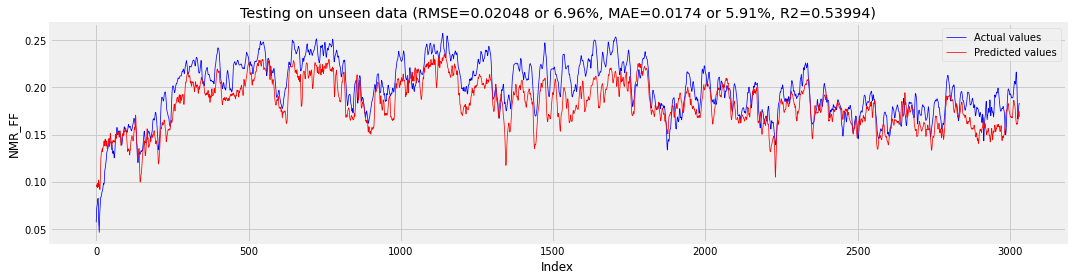


****************************************************************************************************



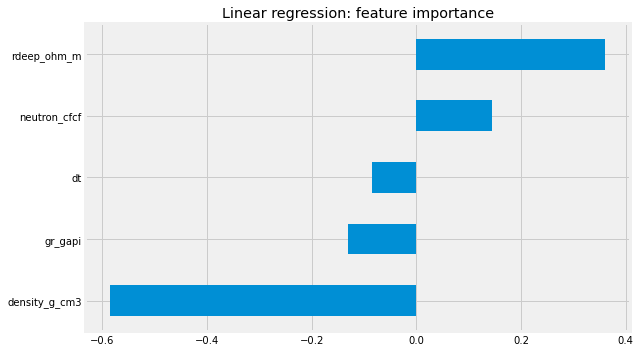


****************************************************************************************************

RESULTS FOR TESTING ON WELL MC393-1
 Test set: 2709 data points (well MC393-1)
Train set: 9807 data points (all other wells)


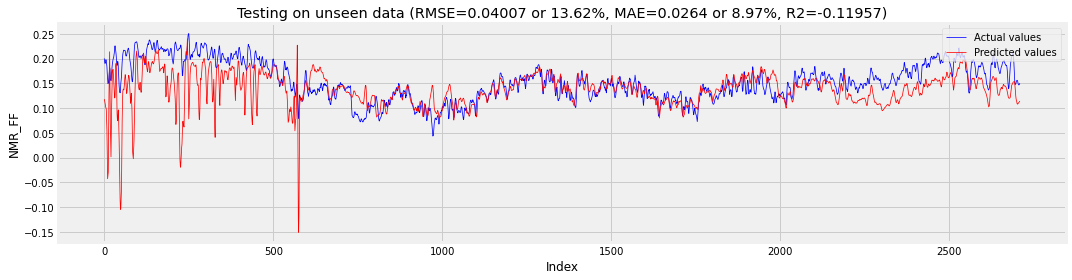


****************************************************************************************************



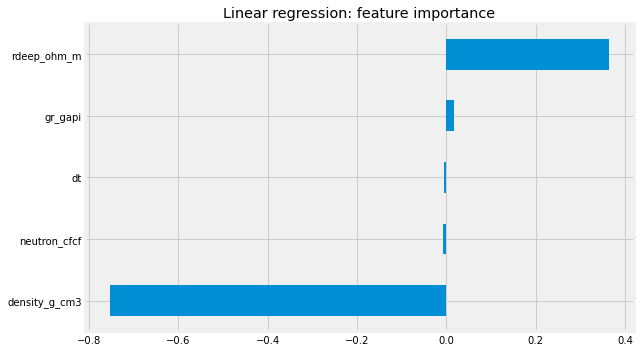


****************************************************************************************************

RESULTS FOR TESTING ON WELL MC525-2
 Test set: 874 data points (well MC525-2)
Train set: 11642 data points (all other wells)


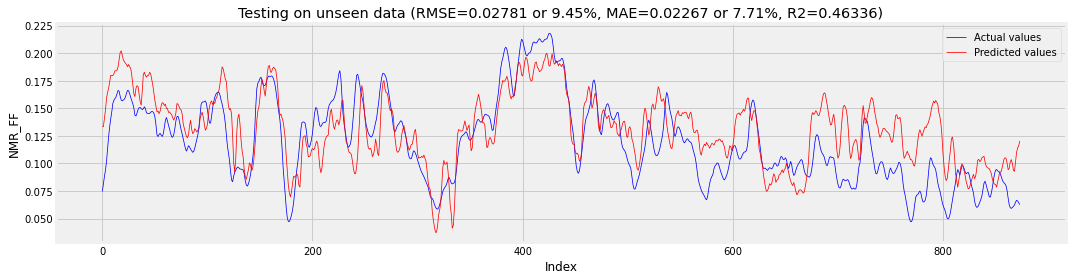


****************************************************************************************************



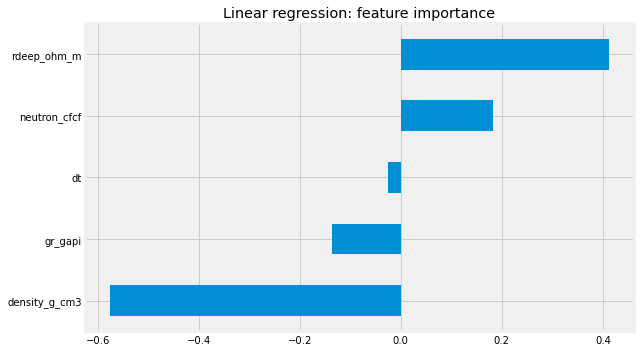


****************************************************************************************************

RESULTS FOR TESTING ON WELL MC612-1BP1
 Test set: 1687 data points (well MC612-1BP1)
Train set: 10829 data points (all other wells)


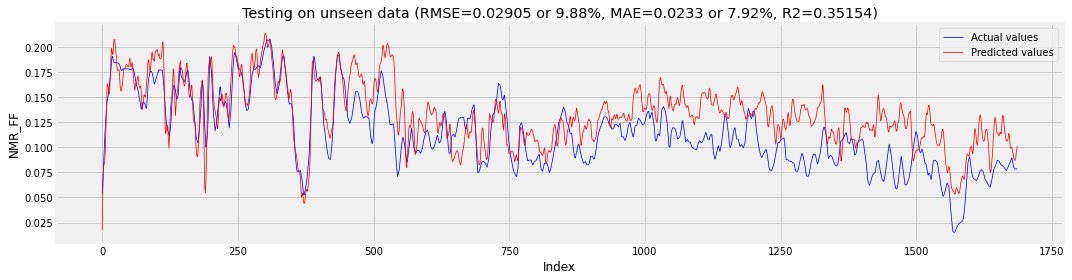


****************************************************************************************************



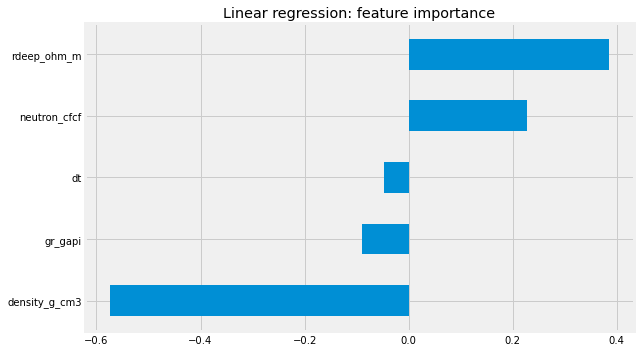


****************************************************************************************************



In [39]:
print('Selected features to build model:', [i for i in all_features if 'nmr' not in i])
print('    Target value being predicted:', [i for i in all_features if 'nmr' in i])
print()

metrics = []
for well in df_original['wellname'].unique():
    print('RESULTS FOR TESTING ON WELL {}'.format(well.upper()))
    rmse, mae, r2 = linear_reg(df_original, all_features, well, plotting=True)
    metrics.append((rmse, mae, r2))

In [40]:
diff = df_original['nmr_ff_vv'].max() - df_original['nmr_ff_vv'].min()
rmse = sum([i[0] for i in metrics]) / len(metrics)
mae  = sum([i[1] for i in metrics]) / len(metrics)
r2   = sum([i[2] for i in metrics]) / len(metrics)

print('Average RMSE = {} which is {}%'.format(round(rmse, 5), round((rmse / diff)*100, 2)))
print('Average MAE  = {} which is {}%'.format(round(mae, 5), round((mae / diff)*100, 2)))
print('Average R2   = {}'.format(round(r2, 5)))

Average RMSE = 0.03103 which is 10.55%
Average MAE  = 0.02483 which is 8.44%
Average R2   = 0.23689


## Random Forest

In [41]:
def rf_reg(df, _all_features, well_name, plotting=False):
        
    # one of all_features is target to be predicted
    _target = 'nmr_ff_vv'
    _features = [i for i in _all_features if i != _target]
        
    # train / test split
    df = deepcopy(df)
    test_index = df[df['wellname'] == well_name].index
    X_test = df.loc[test_index][_features].values
    y_test = df.loc[test_index][_target].values.reshape(-1, 1)
    
    X_train = df[_features].drop(test_index).values
    y_train = df[_target].drop(test_index).values.reshape(-1, 1)
    if plotting:
        print(' Test set: {} data points (well {})'.format(X_test.shape[0], well_name))
        print('Train set: {} data points (all other wells)'.format(X_train.shape[0]))
        
    # fit scaler on train set and apply to both train and test sets
    feature_scaler, target_scaler = StandardScaler(), StandardScaler()
    feature_scaler.fit(X_train)
    target_scaler.fit(y_train)
    
    X_train, X_test = feature_scaler.transform(X_train), feature_scaler.transform(X_test)
    y_train, y_test = target_scaler.transform(y_train), target_scaler.transform(y_test)
        
    # train and test model, inverse transform predictions (best n_neighbors=50)
    regressor = RandomForestRegressor(n_estimators=500)
    regressor.fit(X_train, y_train)
    _r2 = regressor.score(X_test, y_test)
    yhat = regressor.predict(X_test)
    yhat = target_scaler.inverse_transform(yhat)
        
    # estimate metrics and plot results
    _rmse = mean_squared_error(df.loc[test_index][_target].values, yhat, squared=False)          # False for rmse
    _mae  = mean_absolute_error(df.loc[test_index][_target].values, yhat)
    diff = df['nmr_ff_vv'].max() - df['nmr_ff_vv'].min()

    if plotting:
        plot_results(df.loc[test_index][_target].values, yhat, _rmse, _mae, _r2, diff)
        print('\n' + '*'*100 + '\n')
        
        coeff_df = pd.DataFrame({'Feature Importance' : regressor.feature_importances_}, index=_features)
        coeff_df = coeff_df.sort_values(by='Feature Importance')
        coeff_df.plot(kind='barh', figsize=(9, 5), legend=False, title="Random forest: feature importance")
        plt.tight_layout()
        plt.show()
        
        print('\n' + '*'*100 + '\n')
        
    return _rmse, _mae, _r2

Selected features to build model: ['density_g_cm3', 'rdeep_ohm_m', 'gr_gapi', 'neutron_cfcf', 'dt']
    Target value being predicted: ['nmr_ff_vv']

RESULTS FOR TESTING ON WELL MC348-3ST1
 Test set: 551 data points (well MC348-3ST1)
Train set: 11965 data points (all other wells)


C:\Users\andrew.nedilko\Anaconda3\envs\ssedb\lib\site-packages\ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


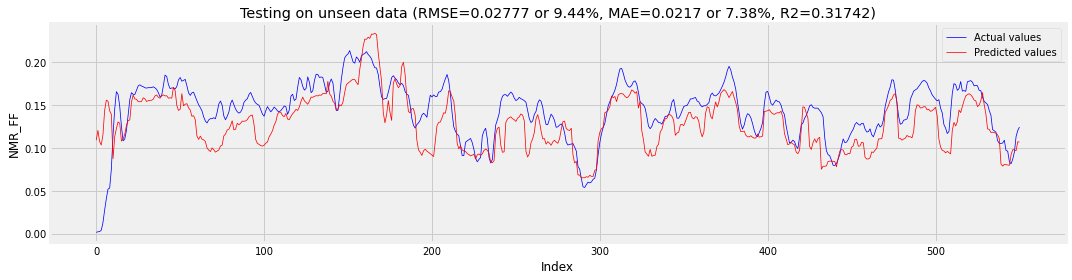


****************************************************************************************************



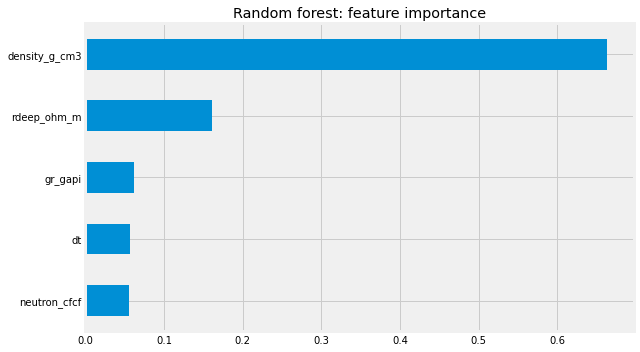


****************************************************************************************************

RESULTS FOR TESTING ON WELL MC391-1
 Test set: 2713 data points (well MC391-1)
Train set: 9803 data points (all other wells)


C:\Users\andrew.nedilko\Anaconda3\envs\ssedb\lib\site-packages\ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


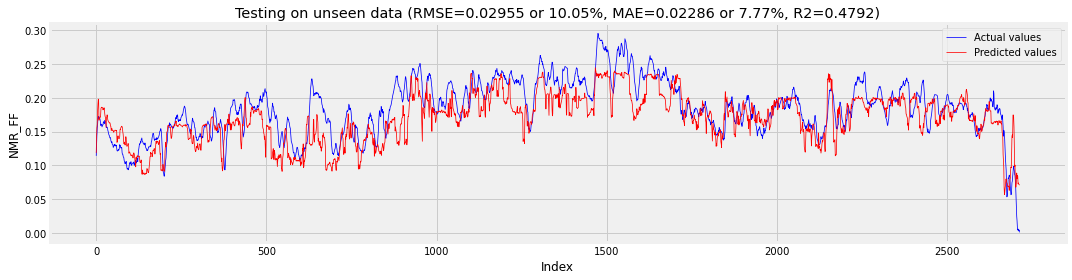


****************************************************************************************************



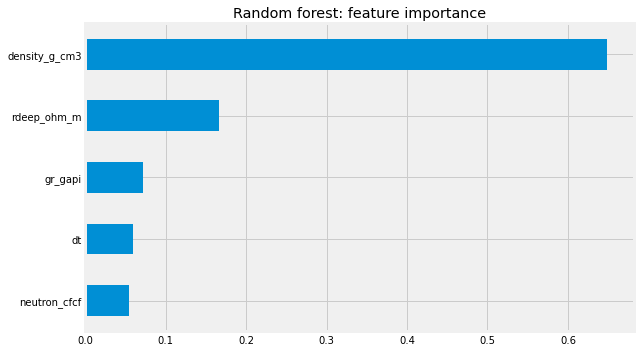


****************************************************************************************************

RESULTS FOR TESTING ON WELL MC392-1
 Test set: 950 data points (well MC392-1)
Train set: 11566 data points (all other wells)


C:\Users\andrew.nedilko\Anaconda3\envs\ssedb\lib\site-packages\ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


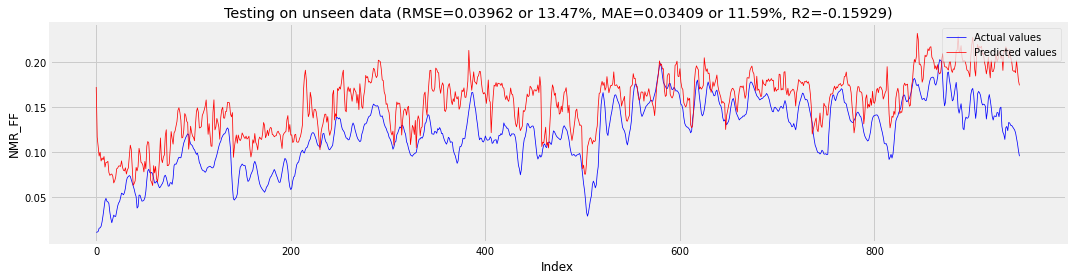


****************************************************************************************************



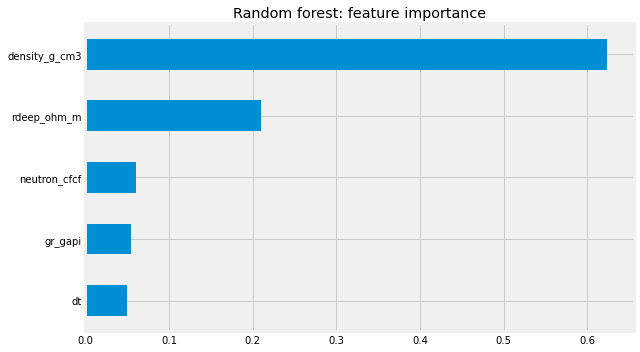


****************************************************************************************************

RESULTS FOR TESTING ON WELL MC392-1ST1
 Test set: 3032 data points (well MC392-1ST1)
Train set: 9484 data points (all other wells)


C:\Users\andrew.nedilko\Anaconda3\envs\ssedb\lib\site-packages\ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


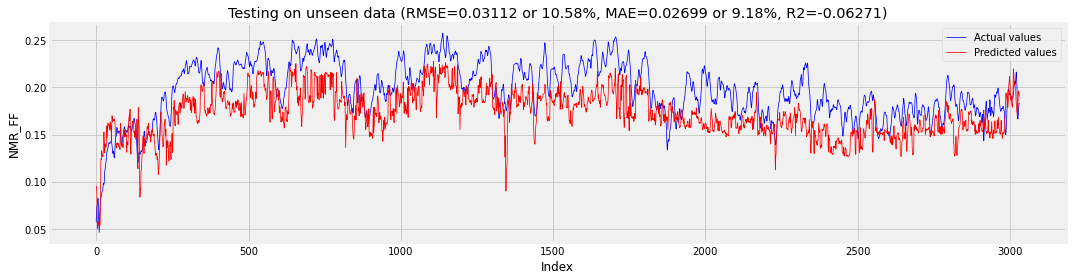


****************************************************************************************************



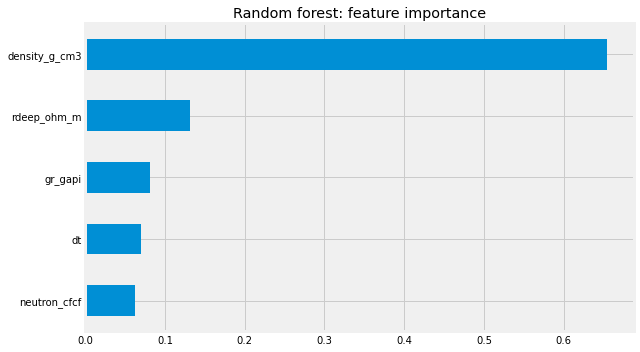


****************************************************************************************************

RESULTS FOR TESTING ON WELL MC393-1
 Test set: 2709 data points (well MC393-1)
Train set: 9807 data points (all other wells)


C:\Users\andrew.nedilko\Anaconda3\envs\ssedb\lib\site-packages\ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


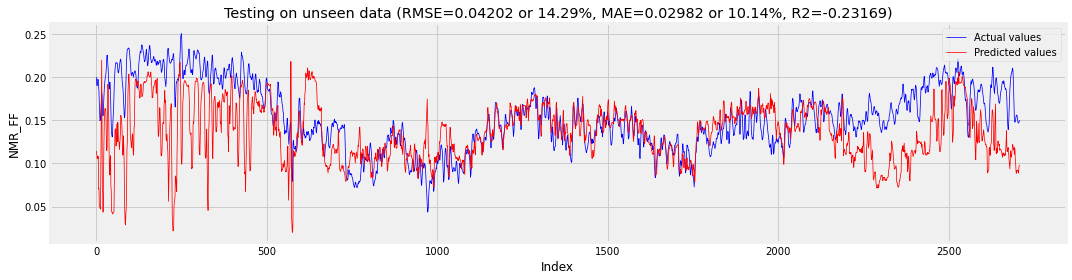


****************************************************************************************************



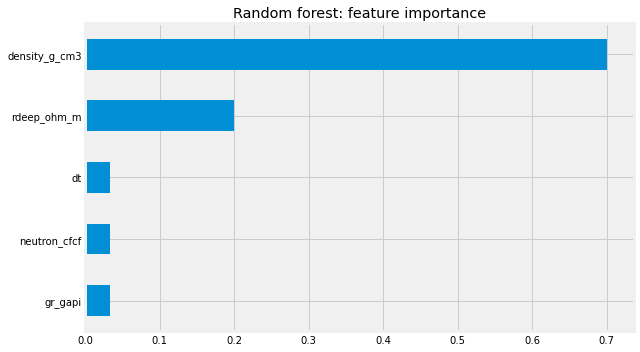


****************************************************************************************************

RESULTS FOR TESTING ON WELL MC525-2
 Test set: 874 data points (well MC525-2)
Train set: 11642 data points (all other wells)


C:\Users\andrew.nedilko\Anaconda3\envs\ssedb\lib\site-packages\ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


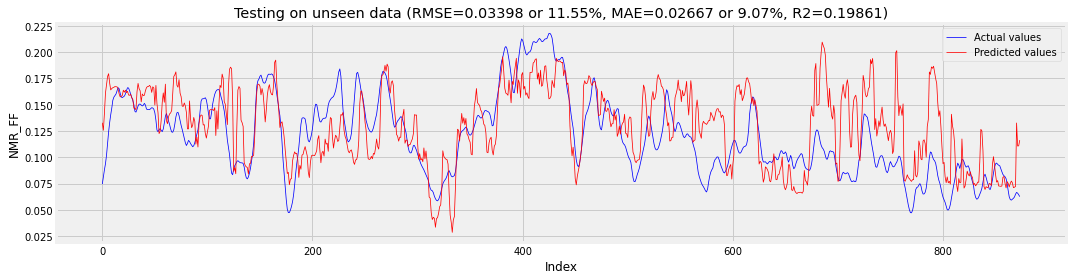


****************************************************************************************************



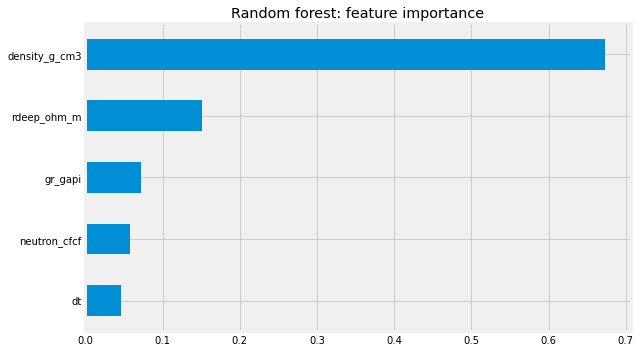


****************************************************************************************************

RESULTS FOR TESTING ON WELL MC612-1BP1
 Test set: 1687 data points (well MC612-1BP1)
Train set: 10829 data points (all other wells)


C:\Users\andrew.nedilko\Anaconda3\envs\ssedb\lib\site-packages\ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


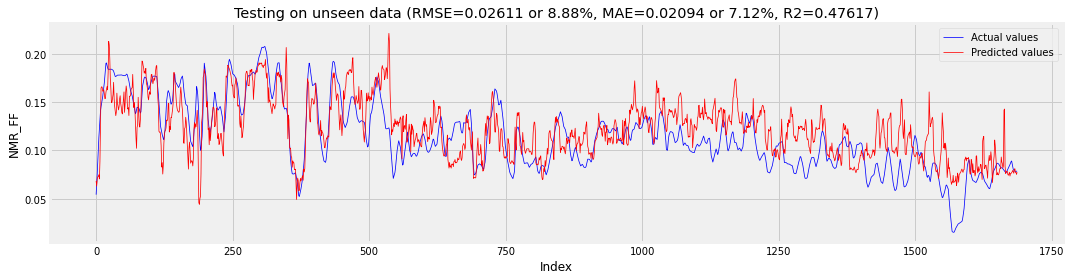


****************************************************************************************************



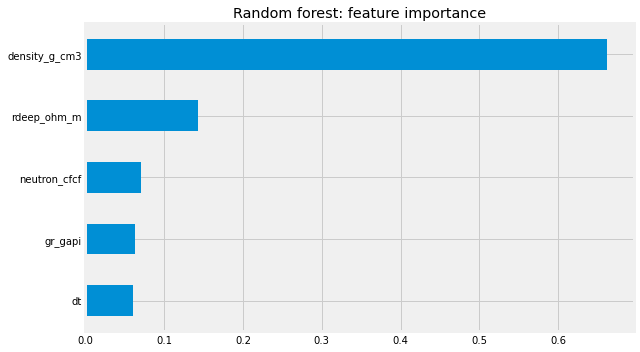


****************************************************************************************************



In [42]:
print('Selected features to build model:', [i for i in all_features if 'nmr' not in i])
print('    Target value being predicted:', [i for i in all_features if 'nmr' in i])
print()

metrics = []
for well in df_original['wellname'].unique():
    print('RESULTS FOR TESTING ON WELL {}'.format(well.upper()))
    rmse, mae, r2 = rf_reg(df_original, all_features, well, plotting=True)
    metrics.append((rmse, mae, r2))

In [43]:
diff = df_original['nmr_ff_vv'].max() - df_original['nmr_ff_vv'].min()
rmse = sum([i[0] for i in metrics]) / len(metrics)
mae  = sum([i[1] for i in metrics]) / len(metrics)
r2   = sum([i[2] for i in metrics]) / len(metrics)

print('Average RMSE = {} which is {}%'.format(round(rmse, 5), round((rmse / diff)*100, 2)))
print('Average MAE  = {} which is {}%'.format(round(mae, 5), round((mae / diff)*100, 2)))
print('Average R2   = {}'.format(round(r2, 5)))

Average RMSE = 0.03288 which is 11.18%
Average MAE  = 0.02615 which is 8.89%
Average R2   = 0.14539
